# Image classification with Swin Transformers

**Author:** [Rishit Dagli](https://twitter.com/rishit_dagli)<br>
**Date created:** 2021/09/08<br>
**Last modified:** 2021/09/08<br>
**Description:** Image classification using Swin Transformers, a general-purpose backbone for computer vision.

This example implements
[Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)
by Liu et al. for image classification, and demonstrates it on the
[CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Swin Transformer (**S**hifted **Win**dow Transformer) can serve as a
general-purpose backbone for computer vision. Swin Transformer is a hierarchical
Transformer whose representations are computed with _shifted windows_. The
shifted window scheme brings greater efficiency by limiting self-attention
computation to non-overlapping local windows while also allowing for
cross-window connections. This architecture has the flexibility to model
information at various scales and has a linear computational complexity with
respect to image size.

This example requires TensorFlow 2.5 or higher.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # For tf.data and preprocessing only.
print(tf.config.list_physical_devices('GPU'))
import keras
from keras import layers
from keras import ops
import cv2
import imutils
import random
import matplotlib.pyplot as plt

2024-02-07 16:08:35.885714: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 16:08:35.885797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 16:08:35.921653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 16:08:36.002185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 16:08:37.068702: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-07 16:08:40.568256: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 16:08:40.702614: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 16:08:40.702831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Configure the hyperparameters

A key parameter to pick is the `patch_size`, the size of the input patches.
In order to use each pixel as an individual input, you can set `patch_size` to
`(1, 1)`. Below, we take inspiration from the original paper settings for
training on ImageNet-1K, keeping most of the original settings for this example.

In [2]:
num_classes = 33
input_shape = (32,32,1)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 16
num_epochs = 200
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1


sr = cv2.dnn_superres.DnnSuperResImpl_create() 
path = "../models/LapSRN_x8.pb" 
sr.readModel(path)
sr.setModel("lapsrn",8)

## Prepare the data

We load the CIFAR-100 dataset through `keras.datasets`,
normalize the images, and convert the integer labels to one-hot encoded vectors.

(32, 32)


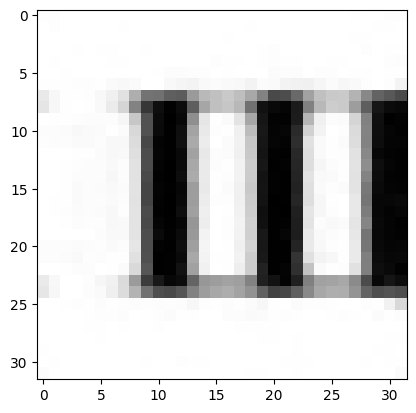

In [3]:
from utils.letter_extraction import *

let = cv2.imread('../data/letterlist.jpg', 0)
let = let[15:780,:]
num_letters = 33
num_fonts = 21

def crop_image(img, trashold=250):
    top = 0
    bottom =0
    left = 0
    right = 0
    for i in range(img.shape[0]):
        if img[i,:].mean() > trashold:
            top = i
        else:
            break
    for i in range(img.shape[0]):
        if img[-i,:].mean() > trashold:
            bottom = i
        else:
            break
    for i in range(img.shape[1]):
        if img[:,i].mean() > trashold:
            left = i
        else:
            break
    for i in range(img.shape[1]):
        if img[:,-i].mean() > trashold:
            right = i
        else:
            break
    left = max(1,left)
    right = max(1,right)
    top = max(1,top)
    bottom = max(1,bottom)
    img = img[top:-bottom, left:-right]

    return img

def get_letter(font_num, letter_num,  resoluter = sr):
    img = let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
    img_croped = crop_image(img)    
    h,w = img_croped.shape    
    size_max = max(w, h)
    letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
    
    if w > h:
        # Enlarge image top-bottom
        # ------
        # ======
        # ------
        y_pos = size_max // 2 - h // 2
        letter_square[y_pos:y_pos + h, 0:w] = img_croped[:h, :w]
    elif w < h:
        # Enlarge image left-right
        # --||--
        x_pos = size_max // 2 - w // 2
        letter_square[0:h, x_pos:x_pos + w] = img_croped[:h, :w]
    else:
        letter_square = img_croped    
    
    
    letter_square = resoluter.upsample(letter_square)
    letter_square = cv2.resize(letter_square,input_shape[:-1])
    
    return letter_square

def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]
test = get_letter(3,10)
print(test.shape)
plt.imshow(test, cmap='gray')

In [4]:
class BaseAugmenter():
    def __init__(self, chanse=0.5):
        self.chance = chanse
        
    def __call__(self, img, *args, **kwargs):
        augmented = False
        if random.random()<= self.chance:
            try:
                img = self._apply(img, *args, **kwargs)
                augmented = True
            except Exception as e:
                print(e)
            
        return img, augmented
    
    def _apply(self, img, *args, **kwargs):
        return img
    
class NoiseAugmenter(BaseAugmenter):
    def _apply(self, letter, max=30):
        max = (255-np.array(letter)).max()*max/100
        noise = np.random.normal(size=(letter.shape))*max
        return letter+noise
    
class FlipAugmenter(BaseAugmenter):

    def _apply(self, letter, mode='horizontal'):
        if mode == 'horizontal':
            return np.flip(letter, axis=0)
        elif mode == 'vertical':
            return np.flip(letter, axis=1)
        elif mode == 'random':
            axis = random.random() < 0.5
            return np.flip(letter, axis=int(axis))
        
class RotationAugmenter(BaseAugmenter):
    
    def _apply(self, letter, angle=60):
        image = np.zeros_like(letter) + 255 - letter
        rotated = imutils.rotate_bound(image, angle)
        rotated = np.zeros_like(rotated) + 255 - rotated
        rotated = cv2.resize(rotated, (letter.shape[1], letter.shape[0]))
        return rotated
    
class BlurAugmenter(BaseAugmenter):
    
    def _apply(self, letter, kernel_size=3):
        return cv2.medianBlur(letter, kernel_size)

class MultipleAugmenter():
    NOISE_CHANCE = 0.1
    NOISE_HARDNESS = 20
    
    FLIP_CHANCE = 0.3
    
    ROTATE_CHANCE = 0.15
    
    BLUR_CHANCE = 0.99
    BLUR_HARD_CHANCE = 0.05
    
    images = []
    captions = []
    
    def __init__(self, images, captions):
        self.images_orig = images
        self.captions_orig = captions
        self.augmenters = [
            FlipAugmenter(self.FLIP_CHANCE),
            RotationAugmenter(self.ROTATE_CHANCE),
            BlurAugmenter(self.BLUR_CHANCE),
            BlurAugmenter(self.BLUR_HARD_CHANCE),
            
        ]
        self.noise = (NoiseAugmenter(self.NOISE_CHANCE), self.NOISE_HARDNESS)
        
        self.augment_args = [
            ['random'],
            [],
            [3],
            [5],

        ]    
    
    def random_augment(self, rounds = 1, seed = 42, save_last=False):
        random.seed(seed)
        
        images = self.images_orig
        captions = self.captions_orig
        
        for _ in range(rounds):
            print(len(images))
            num_images = len(images)
            for n in range(num_images):
                image = images[n]
                caption = captions[n]
                
                for n, aug in enumerate(self.augmenters):
                    aug_args = self.augment_args[n]
                    if not aug_args:
                        aug_args = [random.randint(-15,15)]
                    image, augmented = aug(image, *aug_args)
                    if augmented:
                        images.append(image)
                        captions.append(caption)
                    
            if save_last:
                images = images[num_images:]
                captions = captions[num_images:]
        

                
        self.images = images
        self.captions = captions
        self._smooth(0.9)
        self._apply_noise()
        self._normalize()

        
    def _apply_noise(self):
        for n, im in enumerate(self.images):
            noise_augmenter, hardeness = self.noise
            image, augmented = noise_augmenter(im, hardeness)
            if augmented:
                self.images[n] = image        
        
    def _normalize(self):
        for n, im in enumerate(self.images):
            im = np.array(im)
            self.images[n] = im/im.max()
            
    def _smooth(self, probability=0.5):
        for n, im in enumerate(self.images):

            if random.random() < probability:
                im = np.array(im)
                self.images[n] = cv2.GaussianBlur(im, (7,7), 1)

In [5]:
images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

aug = MultipleAugmenter(images.copy(), captions.copy())
aug.random_augment(5)
test_aug = MultipleAugmenter(images.copy(), captions.copy())
test_aug.random_augment(3, 65, 0)

693
1726
4293
10680
26526
693
1714
4259


In [6]:
aug.images[0].shape

(32, 32)

In [7]:
x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)

num_train_samples = int(len(x_data) * (1 - validation_split))
num_val_samples = len(x_data) - num_train_samples
x_train, x_val = np.split(x_data, [num_train_samples])
y_train, y_val = np.split(y_data, [num_train_samples])

test_x_data = np.array(test_aug.images)
test_x_data = test_x_data.reshape(*test_x_data.shape,1)

test_classes = list(map(captions_base.index, test_aug.captions))
test_y_data = keras.utils.to_categorical(test_classes, num_classes=num_letters)

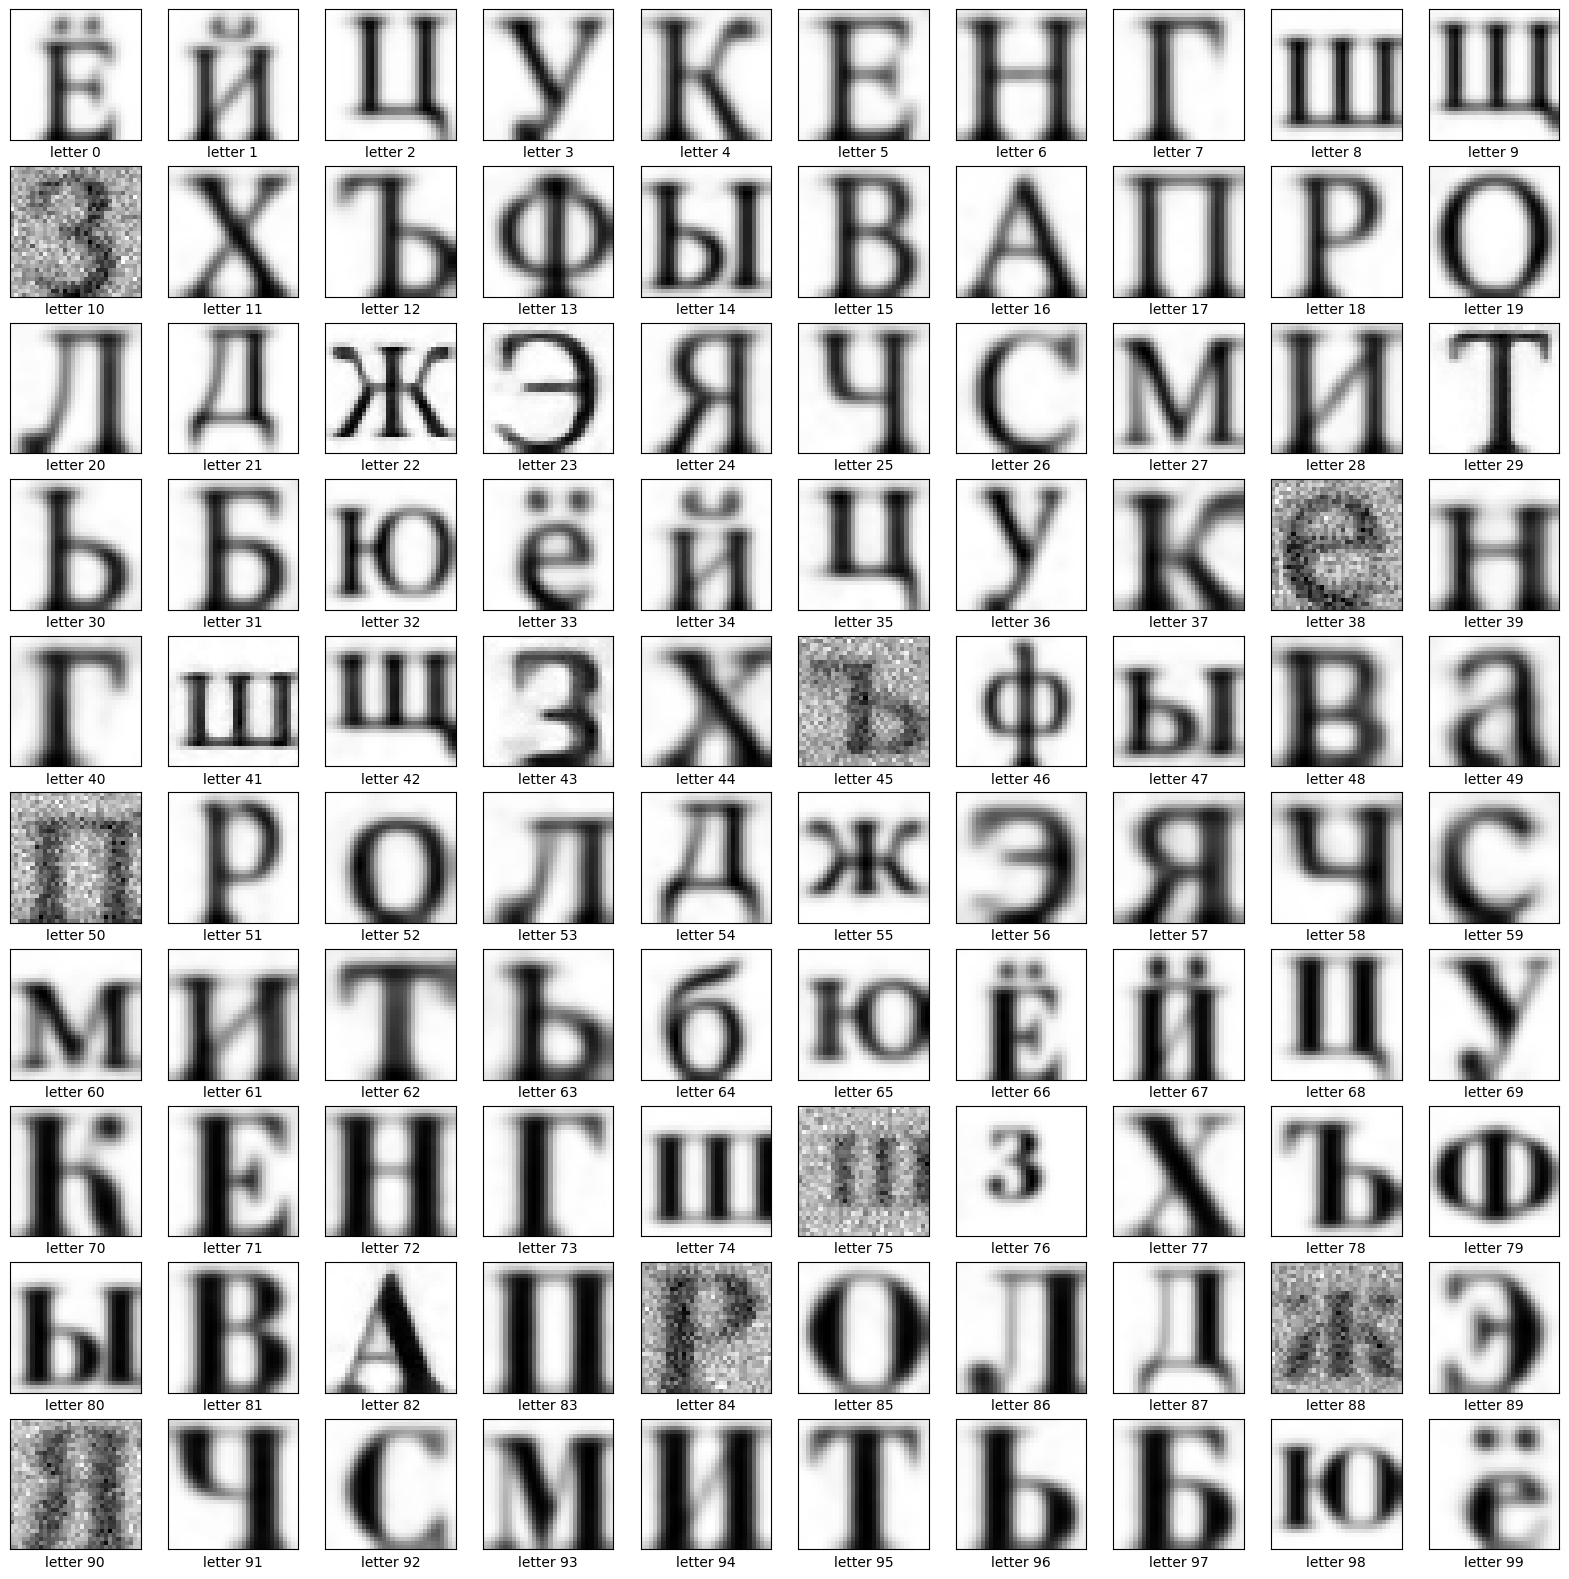

In [8]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
n=0
for j in range(n,n+100):
    i = j-n
    ax[i//10, i%10].imshow(aug.images_orig[j], cmap='gray')
    ax[i//10, i%10].set_xticks([])
    ax[i//10, i%10].set_yticks([])
    ax[i//10, i%10].set_xlabel(f'letter {j}')

## Helper functions

We create two helper functions to help us get a sequence of
patches from the image, merge patches, and apply dropout.

In [9]:

from utils.funcs import *


## Window based multi-head self-attention

Usually Transformers perform global self-attention, where the relationships
between a token and all other tokens are computed. The global computation leads
to quadratic complexity with respect to the number of tokens. Here, as the
[original paper](https://arxiv.org/abs/2103.14030) suggests, we compute
self-attention within local windows, in a non-overlapping manner. Global
self-attention leads to quadratic computational complexity in the number of
patches, whereas window-based self-attention leads to linear complexity and is
easily scalable.

In [10]:
from utils.layers import WindowAttention


## The complete Swin Transformer model

Finally, we put together the complete Swin Transformer by replacing the standard
multi-head attention (MHA) with shifted windows attention. As suggested in the
original paper, we create a model comprising of a shifted window-based MHA
layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying
`LayerNormalization` before each MSA layer and each MLP, and a residual
connection after each of these layers.

Notice that we only create a simple MLP with 2 Dense and
2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is
quite standard in the literature. However in this paper the authors use a
2-layer MLP with GELU nonlinearity in between.

In [11]:
from utils.layers import SwinTransformer

## Model training and evaluation

### Extract and embed patches

We first create 3 layers to help us extract, embed and merge patches from the
images on top of which we will later use the Swin Transformer class we built.

In [12]:
# Using tf ops since it is only used in tf.data.

from utils.layers import PatchMerging, PatchEmbedding


### Prepare the tf.data.Dataset

We do all the steps, which do not have trainable weights with tf.data.
Prepare the training, validation and testing sets.

In [13]:
def augment(x):
    return x


dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((test_x_data, test_y_data))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

2024-02-07 16:08:51.375967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 16:08:51.376272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 16:08:51.376443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
# x_train[0].mean(), test_x_data[0].mean(), real_data[0].mean()

In [15]:
len(test_x_data)

10570

### Build the model

We put together the Swin Transformer model.

In [16]:
input = layers.Input(shape=(256, 4))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
dense = keras.layers.Dense(1024, activation='relu')(x)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
output = layers.Dense(num_classes, activation="softmax")(dense)
model = keras.Model(input, output)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 4)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_embedding                 │ (None, 256, 64)           │     16,704 │
│ (PatchEmbedding)                │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer                │ (None, 256, 64)           │     50,072 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer_1              │ (None, 256, 64)           │     51,096 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_merging (PatchMerging)    │ (None, 64, 128)           │     32,768 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d        │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 1024)              │    132,096 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 947,345 (3.62 MB)

 Trainable params: 946,289 (3.61 MB)

 Non-trainable params: 1,056 (8.25 KB)

In [18]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta = 1e-3,
                              patience=5, min_lr=1e-8)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=7, start_from_epoch=30)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs")
checkpoint_filepath = f"tmp/swin_checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_categorical_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

callbacks = [reduce_lr, early_stop, tensorboard, checkpoint_callback]

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(3, name="top-3-accuracy"),
    ],
)

history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
    callbacks= callbacks
)

Epoch 1/200
3715/3715 ━━━━━━━━━━━━━━━━━━━━ 56s 11ms/step - accuracy: 0.5638 - loss: 1.7985 - top-3-accuracy: 0.8318 - val_accuracy: 0.5474 - val_loss: 1.8915 - val_top-3-accuracy: 0.8131 - learning_rate: 0.0010
Epoch 2/200
3715/3715 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.7342 - loss: 1.3770 - top-3-accuracy: 0.9275 - val_accuracy: 0.6626 - val_loss: 1.6518 - val_top-3-accuracy: 0.8816 - learning_rate: 0.0010
Epoch 3/200
3715/3715 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8131 - loss: 1.1899 - top-3-accuracy: 0.9579 - val_accuracy: 0.6838 - val_loss: 1.5147 - val_top-3-accuracy: 0.9008 - learning_rate: 0.0010
Epoch 4/200
3715/3715 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8649 - loss: 1.0641 - top-3-accuracy: 0.9722 - val_accuracy: 0.7327 - val_loss: 1.4364 - val_top-3-accuracy: 0.9119 - learning_rate: 0.0010
Epoch 5/200
3715/3715 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8865 - loss: 1.0098 - top-3-accuracy: 0.9776 - val_accuracy: 0.7224 - val_loss: 1.4902 - 

Let's visualize the training progress of the model.

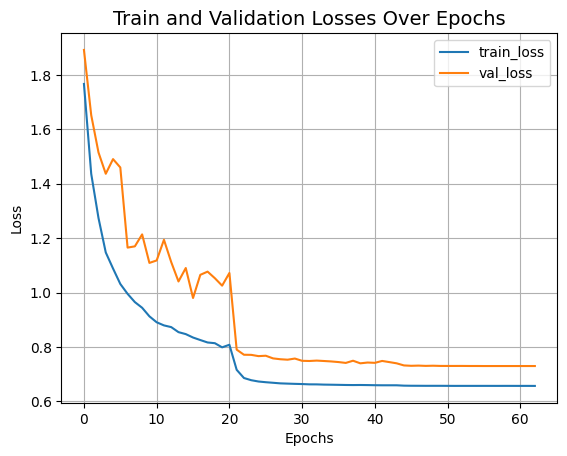

In [19]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [20]:
# loss, accuracy, top_5_accuracy = model.evaluate(dataset_test)
# print(f"Test loss: {round(loss, 2)}")
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [21]:
model.save('../models/swin.keras')
model.save_weights('../models/swin.weights.h5')

In [22]:
# keras.utils.plot_model(model,'models/swin.jpg')

In [23]:
# model.load_weights('tmp/checkpoint81.weights.h5')

# Load other models to compare

In [24]:
ViT = keras.saving.load_model('../models/vit_letter_recognizer.keras')
ViT.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [25]:
CNN = keras.saving.load_model('../models/conv_letter_recognizer.keras')
CNN.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [26]:
models = [CNN, ViT]

In [27]:
evals = []
for m in models: 
    evals.append(m.evaluate(test_x_data, test_y_data))
evals.append(model.evaluate(dataset_test))
evals

331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0735 - loss: 3.4765 - top-5-accuracy: 0.2207
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0897 - loss: 39.0912 - top-5-accuracy: 0.2579
661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9897 - loss: 0.6903 - top-3-accuracy: 0.9973


[[3.4778547286987305, 0.07492904365062714, 0.22024597227573395],
 [38.775787353515625, 0.09120151400566101, 0.2605487108230591],
 [0.7093058228492737, 0.9838221669197083, 0.99593186378479]]

In [28]:
preds = []

for m in models: 
    preds.append(m.predict(test_x_data))
preds.append(model.predict(dataset_test))

331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [29]:
test_x_data.shape

(10570, 32, 32, 1)

In [30]:
CNN.summary(), ViT.summary(), model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)       │      1,280 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 1024)              │  8,389,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 10,530,849 (40.17 MB)

 Trainable params: 10,530,849 (40.17 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape_1 (Reshape)             │ (None, 32, 32)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_4           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_5           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_6           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_7           │ (None, 32, 32)            │     69,896 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 1024)              │  1,049,600 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_14 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_15 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,993,793 (7.61 MB)

 Trainable params: 1,993,793 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 4)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_embedding                 │ (None, 256, 64)           │     16,704 │
│ (PatchEmbedding)                │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer                │ (None, 256, 64)           │     50,072 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ swin_transformer_1              │ (None, 256, 64)           │     51,096 │
│ (SwinTransformer)               │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ patch_merging (PatchMerging)    │ (None, 64, 128)           │     32,768 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling1d        │ (None, 128)               │          0 │
│ (GlobalAveragePooling1D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 1024)              │    132,096 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 2,839,925 (10.84 MB)

 Trainable params: 946,289 (3.61 MB)

 Non-trainable params: 1,056 (8.25 KB)

 Optimizer params: 1,892,580 (7.22 MB)

(None, None, None)

In [31]:
test_pred = model.predict(dataset_test)

661/661 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


661/661 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step


Text(0, 0.5, 'Predicted letters')

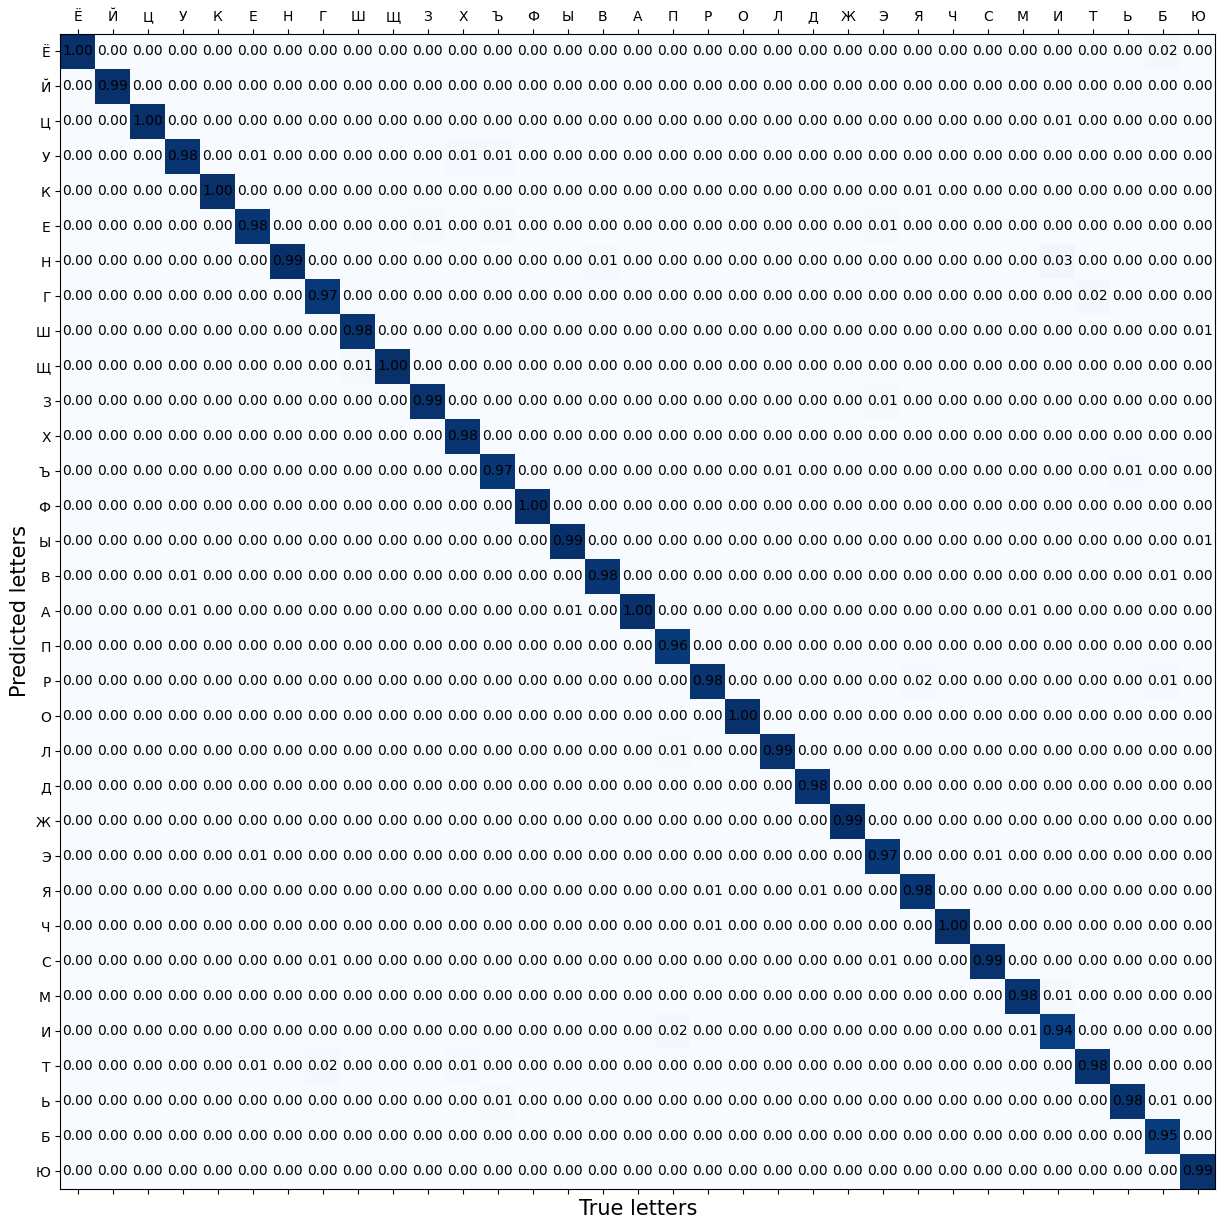

In [32]:
y_pred = model.predict(dataset_test).argmax(axis=1)
mat = np.zeros(shape=(num_letters,num_letters))
for i in range(len(y_pred)):
    true_ind = test_classes[i]
    pred_ind = y_pred[i]    
    mat[true_ind, pred_ind]+=1

mat=mat/mat.sum(axis=0)

fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, cmap='Blues')
ax.set_xticks(range(len(captions_base)), captions_base)
ax.set_yticks(range(len(captions_base)), captions_base)
for i in range(len(captions_base)):
    for j in range(len(captions_base)):
        c = mat[j,i]
        ax.text(i, j, f'{c:.2f}', va='center', ha='center')
ax.set_xlabel('True letters', fontsize=15)
ax.set_ylabel('Predicted letters', fontsize=15)